# Videte Wheel
## Install Requirements

In [1]:
!conda install -y control slycot tqdm

Solving environment: done

# All requested packages already installed.



## Videte Wheel Kinematics
### Basic Definitions

In [2]:
import sympy

# Declare Time
t = sympy.symbols('t')

# Declare Functions
y = sympy.Function('y')(t)
θ = sympy.Function('θ')(t)
ρ = sympy.Function('ρ')(t)
φ = sympy.Function('φ')(t)

# Declare Masses
m_ow, m_ow_rot, m_iw, m_iw_rot, m_m = sympy.symbols('m_ow m_owr m_iw m_iwr m_m')

# Declare Dimensions
l_iw_m, r_1, r_2, r_3 = sympy.symbols('l_iwm r_1 r_2 r_3')
l_ow_iw = r_2 - r_1

# Declare Gravity
g = sympy.symbols('g')

In [3]:
# Gear ratio
i_gear = r_2 / r_1

# Linking rotation of outer and inner wheel
φ_iw = φ
φ_ow = (1/i_gear) * φ_iw

ω = φ.diff(t)
ω_iw = ω
ω_ow = φ_ow.diff(t)

In [4]:
# Y positions
y_ow = r_3 + y
y_iw = y_ow - l_ow_iw * sympy.cos(ρ)
y_m = y_iw + l_iw_m * sympy.cos(θ)

# Rotation based x movement
# TODO: Check to be correct
x = r_3 * (φ_ow - ρ)

# X positions
x_ow = x
x_iw = x_ow + l_ow_iw * sympy.sin(ρ)
x_m = x_iw + l_iw_m * sympy.sin(θ)

### State X

In [5]:
state_x = [θ, θ.diff(t), ρ, ρ.diff(t), φ, φ.diff(t)]

state_x

[θ(t),
 Derivative(θ(t), t),
 ρ(t),
 Derivative(ρ(t), t),
 φ(t),
 Derivative(φ(t), t)]

### Potential Energy

In [6]:
V = (m_m * y_m + m_ow * y_ow + m_iw * y_iw) * g

V

g*(m_iw*(r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_m*(l_iwm*cos(θ(t)) + r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_ow*(r_3 + y(t)))

### Kinetic Energy

In [7]:
# Rotating mass inertia
J_ow = (1/2) * m_ow_rot * (r_2**2 + r_3**2)
J_iw = (1/2) * m_iw_rot * r_1**2

# Kinetic energy of rotating cylinder
W_owr = (1/2) * J_ow * ω_ow**2
W_iwr = (1/2) * J_iw * ω_iw**2

# Translational kinetic energy
W_ow = (1/2) * m_ow * (sympy.diff(x_ow, t)**2 + sympy.diff(y_ow, t)**2)
W_iw = (1/2) * m_iw * (sympy.diff(x_iw, t)**2 + sympy.diff(y_iw, t)**2)
W_m = (1/2) * m_m * (sympy.diff(x_m, t)**2 + sympy.diff(y_m, t)**2)

# Dampening (e.g. heat dissipation)
d_ow, d_iw, d_m, d_owr, d_iwr = sympy.symbols(
    'd_ow d_iw d_m d_owr d_iwr')

W_d_ow = sympy.integrate(
    d_ow * (1/2) * (sympy.diff(x_ow, t)**2 + sympy.diff(y_ow, t)**2), t)
W_d_iw = sympy.integrate(d_iw * (1/2) * sympy.diff(ρ, t)**2, t)
W_d_m = sympy.integrate((d_m * (1/2) * sympy.diff(θ, t)**2), t)
W_d_owr = sympy.integrate(d_owr * (1/2) * ω_ow**2, t)
W_d_iwr = sympy.integrate(d_iwr * (1/2) * ω_iw**2, t)

W_heat = W_d_ow + W_d_iw + W_d_m + W_d_owr + W_d_iwr

# Kinetic Energy
T = W_ow + W_iw + W_m + W_owr + W_iwr + W_heat

T

0.5*d_iw*Integral(Derivative(ρ(t), t)**2, t) + 0.5*d_iwr*Integral(Derivative(φ(t), t)**2, t) + 0.5*d_m*Integral(Derivative(θ(t), t)**2, t) + 0.5*d_ow*(Integral(r_2**2*Derivative(y(t), t)**2, t) + Integral(r_1**2*r_3**2*Derivative(φ(t), t)**2, t) + Integral(r_2**2*r_3**2*Derivative(ρ(t), t)**2, t) + Integral(-2*r_1*r_2*r_3**2*Derivative(ρ(t), t)*Derivative(φ(t), t), t))/r_2**2 + 0.5*d_owr*r_1**2*Integral(Derivative(φ(t), t)**2, t)/r_2**2 + 0.5*m_iw*((r_3*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t)) + (-r_1 + r_2)*cos(ρ(t))*Derivative(ρ(t), t))**2 + (-(r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2) + 0.25*m_iwr*r_1**2*Derivative(φ(t), t)**2 + 0.5*m_m*((-l_iwm*sin(θ(t))*Derivative(θ(t), t) - (r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2 + (l_iwm*cos(θ(t))*Derivative(θ(t), t) + r_3*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t)) + (-r_1 + r_2)*cos(ρ(t))*Derivative(ρ(t), t))**2) + 0.5*m_ow*(r_3**2*(r_1*Derivative(φ(t), t)/r_2 - Derivativ

### Lagrange Equation

In [8]:
L = T - V

L

0.5*d_iw*Integral(Derivative(ρ(t), t)**2, t) + 0.5*d_iwr*Integral(Derivative(φ(t), t)**2, t) + 0.5*d_m*Integral(Derivative(θ(t), t)**2, t) + 0.5*d_ow*(Integral(r_2**2*Derivative(y(t), t)**2, t) + Integral(r_1**2*r_3**2*Derivative(φ(t), t)**2, t) + Integral(r_2**2*r_3**2*Derivative(ρ(t), t)**2, t) + Integral(-2*r_1*r_2*r_3**2*Derivative(ρ(t), t)*Derivative(φ(t), t), t))/r_2**2 + 0.5*d_owr*r_1**2*Integral(Derivative(φ(t), t)**2, t)/r_2**2 - g*(m_iw*(r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_m*(l_iwm*cos(θ(t)) + r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_ow*(r_3 + y(t))) + 0.5*m_iw*((r_3*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t)) + (-r_1 + r_2)*cos(ρ(t))*Derivative(ρ(t), t))**2 + (-(r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2) + 0.25*m_iwr*r_1**2*Derivative(φ(t), t)**2 + 0.5*m_m*((-l_iwm*sin(θ(t))*Derivative(θ(t), t) - (r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2 + (l_iwm*cos(θ(t))*Derivative(θ(t), t) + r_3*(r_1*Derivative(φ(t), t)/r_2 -

In [9]:
f_θ = θ.diff(t)
L_θ = sympy.diff(sympy.diff(L, sympy.diff(θ, t)), t) - sympy.diff(L, θ)
f_dθ = sympy.solve(L_θ, θ.diff(t, t))[0]

f_ρ = ρ.diff(t)
L_ρ = sympy.diff(sympy.diff(L, sympy.diff(ρ, t)), t) - sympy.diff(L, ρ)
f_dρ = sympy.solve(L_ρ, ρ.diff(t, t))[0]

f_φ = φ.diff(t)
L_φ = sympy.diff(sympy.diff(L, sympy.diff(φ, t)), t) - sympy.diff(L, φ)
f_dφ = sympy.solve(L_φ, φ.diff(t, t))[0]

In [10]:
f_dθ

-d_m*Derivative(θ(t), t)/(l_iwm**2*m_m) + g*sin(θ(t))/l_iwm - r_1*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2/l_iwm + r_1*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2))/l_iwm - r_1*r_3*cos(θ(t))*Derivative(φ(t), (t, 2))/(l_iwm*r_2) + r_2*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2/l_iwm - r_2*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2))/l_iwm + r_3*cos(θ(t))*Derivative(ρ(t), (t, 2))/l_iwm + sin(θ(t))*Derivative(y(t), (t, 2))/l_iwm

In [11]:
f_dρ

(-d_iw*r_2*Derivative(ρ(t), t) + d_ow*r_1*r_3**2*Derivative(φ(t), t) - d_ow*r_2*r_3**2*Derivative(ρ(t), t) + g*m_iw*r_1*r_2*sin(ρ(t)) - g*m_iw*r_2**2*sin(ρ(t)) + g*m_m*r_1*r_2*sin(ρ(t)) - g*m_m*r_2**2*sin(ρ(t)) - l_iwm*m_m*r_1*r_2*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 + l_iwm*m_m*r_1*r_2*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) + l_iwm*m_m*r_2**2*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 - l_iwm*m_m*r_2**2*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) - l_iwm*m_m*r_2*r_3*sin(θ(t))*Derivative(θ(t), t)**2 + l_iwm*m_m*r_2*r_3*cos(θ(t))*Derivative(θ(t), (t, 2)) + m_iw*r_1**2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_iw*r_1*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_1*r_2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_iw*r_1*r_2*sin(ρ(t))*Derivative(y(t), (t, 2)) + m_iw*r_1*r_3**2*Derivative(φ(t), (t, 2)) - m_iw*r_2**2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_2**2*sin(ρ(t))*Derivative(y(t), (t, 2)) + m_m*r_1**2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_m*r_1*r_2*r_3*sin(ρ(t))*Derivat

In [12]:
f_dφ

2.0*(-d_iwr*r_2**2*Derivative(φ(t), t) - d_ow*r_1**2*r_3**2*Derivative(φ(t), t) + d_ow*r_1*r_2*r_3**2*Derivative(ρ(t), t) - d_owr*r_1**2*Derivative(φ(t), t) + l_iwm*m_m*r_1*r_2*r_3*sin(θ(t))*Derivative(θ(t), t)**2 - l_iwm*m_m*r_1*r_2*r_3*cos(θ(t))*Derivative(θ(t), (t, 2)) - m_iw*r_1**2*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 + m_iw*r_1**2*r_2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_iw*r_1*r_2**2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_1*r_2**2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_iw*r_1*r_2*r_3**2*Derivative(ρ(t), (t, 2)) - m_m*r_1**2*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 + m_m*r_1**2*r_2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_m*r_1*r_2**2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_m*r_1*r_2**2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_m*r_1*r_2*r_3**2*Derivative(ρ(t), (t, 2)) + m_ow*r_1*r_2*r_3**2*Derivative(ρ(t), (t, 2)))/(r_1**2*(2.0*m_iw*r_3**2 + m_iwr*r_2**2 + 2.0*m_m*r_3**2 + 2.0*m_ow*r_3**2 + m_owr*r_2**2 + m_owr*r_3**2))

In [13]:
state_x

[θ(t),
 Derivative(θ(t), t),
 ρ(t),
 Derivative(ρ(t), t),
 φ(t),
 Derivative(φ(t), t)]

In [14]:
eqs = [f_θ, f_dθ, f_ρ, f_dρ, f_φ, f_dφ]

### Create A Matrix

In [15]:
def createMatrix(eqs: list, states: list) -> sympy.Matrix:
    if (len(eqs) != len(states)):
        print("eqs and states must have the same size")
    A = sympy.zeros(len(eqs), len(eqs))
    for i, eq in enumerate(eqs, start=0):
        for j, state in enumerate(states, start=0):
            A[i, j] = sympy.diff(eq, state)
    return A

In [16]:
A = createMatrix(eqs, state_x)

A

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         0,                                                                                                                                                                                                                                                                                                                                                                                                   

In [17]:
import math

def linearice(A, x, ddx):
    linearice_values = [
        (sympy.sin(θ), math.sin(x[0])),
        (sympy.cos(θ), math.cos(x[0])),
        (sympy.sin(ρ), math.sin(x[2])),
        (sympy.cos(ρ), math.cos(x[2])),
        (θ.diff(t, t), ddx[0]),
        (θ.diff(t), x[1]),
        (θ, x[0]),
        (ρ.diff(t, t), ddx[1]),
        (ρ.diff(t), x[3]),
        (ρ, x[2]),
        (φ.diff(t, t), ddx[2]),
        (φ.diff(t), x[5]),
        (φ, x[4]),
        # Can't move y position (Could .. but should not ..) 
        (y.diff(t, t), 0),
        (y.diff(t), 0),
        (y, 0)
    ]
    return sympy.simplify(A.subs(linearice_values))

In [18]:
A_lin_up = linearice(A, [0, 0, 0, 0, 0, 0], [0, 0, 0])
A_lin_down = linearice(A, [math.pi, 0, 0, 0, 0, 0], [0, 0, 0])

In [19]:
A_lin_up

Matrix([
[          0,                   1,                                                                                                                                                                                                                                                             0,                                                                                                                                                                                                                                   0, 0,                                                                                                                                                                                                                                   0],
[1.0*g/l_iwm, -d_m/(l_iwm**2*m_m),                                                                                                                                                                                                             

In [20]:
A_lin_down

Matrix([
[           0,                   1,                                                                                                                                                                                                                                                             0,                                                                                                                                                                                                                                   0, 0,                                                                                                                                                                                                                                   0],
[-1.0*g/l_iwm, -d_m/(l_iwm**2*m_m),                                                                                                                                                                                                           

### Robot Specifications

In [21]:
masses = {
    g: 9.81,
    m_ow: 1.0,
    m_ow_rot: 0.5,
    m_iw: 0.3,
    m_iw_rot: 0.1,
    m_m: 15.0
}

lengths = {
    l_iw_m: 2.0,
    r_1: 0.25,
    r_2: 1.0,
    r_3: 1.2
}

dampening = {
    d_ow: 1.0,
    d_iw: 1.0,
    d_m: 1.0,
    d_owr: 1.0,
    d_iwr: 1.0
}

specs = {**masses, **lengths, **dampening}

specs

{g: 9.81,
 m_ow: 1.0,
 m_owr: 0.5,
 m_iw: 0.3,
 m_iwr: 0.1,
 m_m: 15.0,
 l_iwm: 2.0,
 r_1: 0.25,
 r_2: 1.0,
 r_3: 1.2,
 d_ow: 1.0,
 d_iw: 1.0,
 d_m: 1.0,
 d_owr: 1.0,
 d_iwr: 1.0}

### Create Jacobian

In [22]:
import numpy as np

A_j_up = np.float64(sympy.simplify(A_lin_up.subs(specs)))
A_j_down = np.float64(sympy.simplify(A_lin_down.subs(specs)))

In [23]:
sympy.Matrix(A_j_up)

Matrix([
[  0.0,                 1.0,               0.0,                0.0, 0.0,                0.0],
[4.905, -0.0166666666666667,               0.0,                0.0, 0.0,                0.0],
[  0.0,                 0.0,               0.0,                1.0, 0.0,                0.0],
[  0.0,                 0.0, -24.8046603867129, -0.537652178703244, 0.0, 0.0793257312840852],
[  0.0,                 0.0,               0.0,                0.0, 0.0,                1.0],
[  0.0,                 0.0,               0.0,  0.238687220288414, 0.0, -0.764130614951102]])

In [24]:
sympy.Matrix(A_j_down)

Matrix([
[   0.0,                 1.0,               0.0,                0.0, 0.0,                0.0],
[-4.905, -0.0166666666666667,               0.0,                0.0, 0.0,                0.0],
[   0.0,                 0.0,               0.0,                1.0, 0.0,                0.0],
[   0.0,                 0.0, -24.8046603867129, -0.537652178703244, 0.0, 0.0793257312840852],
[   0.0,                 0.0,               0.0,                0.0, 0.0,                1.0],
[   0.0,                 0.0,               0.0,  0.238687220288414, 0.0, -0.764130614951102]])

### Design B Matrix

Single motor input (treating both sides of the robot the same)

**FIXME:**
This is only a stub and needs to be done properly in future!

In [25]:
# TODO: Create proper movement matrix (see "Data Driven Design and Engineering" page 302)
B = np.float64(sympy.Matrix([0, -1, 0, 0, 0, 1]))

### Check Controllability

In [26]:
import control
import numpy.linalg as linalg

C_up = control.ctrb(A_j_up, B)
C_down = control.ctrb(A_j_down, B)

rank_up = linalg.matrix_rank(C_up)
rank_down = linalg.matrix_rank(C_down)

print("Rank C up matrix:   " + str(rank_up) + " for " + str(C_up.shape) + " matrix")
print("Rank C down matrix: " + str(rank_down) + " for " + str(C_down.shape) + " matrix")

Rank C up matrix:   6 for (6, 6) matrix
Rank C down matrix: 6 for (6, 6) matrix


In [27]:
sympy.Matrix(control.obsv(A_j_up, C_up))

Matrix([
[                 0.0,                 -1.0, 0.0166666666666667,  -4.90527777777778,    0.16350462962963,   -24.0631125771605],
[                -1.0,   0.0166666666666667,  -4.90527777777778,   0.16350462962963,   -24.0631125771605,    1.20304208461934],
[                 0.0,                  0.0, 0.0793257312840852,  -0.10326487207967,    -1.8643073393359,    3.52530311269295],
[                 0.0,   0.0793257312840852,  -0.10326487207967,   -1.8643073393359,    3.52530311269295,    44.3422405172514],
[                 0.0,                  1.0, -0.764130614951102,  0.602829635003094,  -0.485288584975798, -0.0741624717230674],
[                 1.0,   -0.764130614951102,  0.602829635003094, -0.485288584975798, -0.0741624717230674,   0.898114615766815],
[              -4.905,   0.0166666666666667,   121.673749380268,  -3.08955750149611,                 0.0,    18.1617508939791],
[             0.08175,    -1.00027777777778,  -4.05567680961824,  -4.70603562705845,           

In [28]:
sympy.Matrix(control.obsv(A_j_down, C_down))

Matrix([
[                0.0,                 -1.0, 0.0166666666666667,   4.90472222222222,   -0.16349537037037,   -24.0549375771605],
[               -1.0,   0.0166666666666667,   4.90472222222222,  -0.16349537037037,   -24.0549375771605,    1.20286041795267],
[                0.0,                  0.0, 0.0793257312840852,  -0.10326487207967,    -1.8643073393359,    3.52530311269295],
[                0.0,   0.0793257312840852,  -0.10326487207967,   -1.8643073393359,    3.52530311269295,    44.3422405172514],
[                0.0,                  1.0, -0.764130614951102,  0.602829635003094,  -0.485288584975798, -0.0741624717230674],
[                1.0,   -0.764130614951102,  0.602829635003094, -0.485288584975798, -0.0741624717230674,   0.898114615766815],
[              4.905,   0.0166666666666667,  -121.659969013386,  -8.36197410654908,                 0.0,    18.6066895500987],
[           -0.08175,    -1.00027777777778,   4.05544713683689,   5.27973327386583,                 0.

### Design Cost Matrix Q and R

* Choosen simple default vaules
* Optimize here in future

In [29]:
Q = np.float64(np.diag([1, 1, 1, 1, 1, 1]))
R = np.float64([0.0001])

In [30]:
sympy.Matrix(Q)

Matrix([
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

In [31]:
sympy.Matrix(R)

Matrix([[0.0001]])

### Print Shapes

In [32]:
print("A_down: " + str(A_j_down.shape) + ", A_up: " + str(A_j_up.shape) + ", B: " + str(B.shape) + ", Q: " + str(Q.shape) + ", R: " + str(R.shape))

A_down: (6, 6), A_up: (6, 6), B: (6, 1), Q: (6, 6), R: (1,)


## Generate LQR Controller

In [33]:
K, S, E = control.lqr(A_j_up, B, Q, R)

K_up = np.float64(K)

sympy.Matrix(K_up)

Matrix([[-547.969189494855, -262.22639636428, 61.3932043296494, 1.44079109608265, -99.9999999993695, -117.083843056442]])

In [34]:
K, S, E = control.lqr(A_j_down, B, Q, R)

K_down = np.float64(K)

sympy.Matrix(K_down)

Matrix([[-228.361931147084, -35.1837862887649, -1.78103251521872, 3.32552007569627, 99.9999999999418, 107.963279951084]])

## Simulation

### Uncontrolled Pendulum Simulation

#### Initial Values

In [35]:
import math

dt = 0.01
timeline = np.arange(0., 3., dt)

offset = 0.1
θ_up_0 = offset
θ_down_0 = math.pi + offset

x_0_up = np.float64([θ_up_0, 0, 0, 0, 0, 0])
x_0_down = np.float64([θ_down_0, 0, 0, 0, 0, 0])

In [36]:
sympy.Matrix(x_0_up)

Matrix([
[0.1],
[0.0],
[0.0],
[0.0],
[0.0],
[0.0]])

In [37]:
sympy.Matrix(x_0_down)

Matrix([
[3.24159265358979],
[             0.0],
[             0.0],
[             0.0],
[             0.0],
[             0.0]])

#### Simulation via A matrix

In [38]:
import scipy.integrate as integrate

def apply(y, t):
    return A_local @ y

A_local = A_j_up
solution_up_lin = integrate.odeint(apply, x_0_up, timeline)

A_local = A_j_down
solution_down_lin = integrate.odeint(apply, x_0_down, timeline)

#### Simulation via differential equations

In [39]:
f_θ_c = f_θ.subs(specs)
f_dθ_c = f_dθ.subs(specs)
f_ρ_c = f_ρ.subs(specs)
f_dρ_c = f_dρ.subs(specs)
f_φ_c = f_φ.subs(specs)
f_dφ_c = f_dφ.subs(specs)

In [40]:
f_dθ_c

0.375*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2 + 0.5*sin(θ(t))*Derivative(y(t), (t, 2)) + 4.905*sin(θ(t)) - 0.375*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2)) + 0.6*cos(θ(t))*Derivative(ρ(t), (t, 2)) - 0.15*cos(θ(t))*Derivative(φ(t), (t, 2)) - 0.0166666666666667*Derivative(θ(t), t)

In [41]:
f_dρ_c

1.0*(22.5*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 - 36.0*sin(θ(t))*Derivative(θ(t), t)**2 - 11.475*sin(ρ(t))*Derivative(y(t), (t, 2)) - 13.77*sin(ρ(t))*Derivative(ρ(t), t)**2 - 112.56975*sin(ρ(t)) - 22.5*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) + 36.0*cos(θ(t))*Derivative(θ(t), (t, 2)) - 3.4425*cos(ρ(t))*Derivative(φ(t), (t, 2)) - 2.44*Derivative(ρ(t), t) + 0.36*Derivative(φ(t), t) + 5.868*Derivative(φ(t), (t, 2)))/(32.07825 - 27.54*cos(ρ(t)))

In [42]:
f_dφ_c

5.96718050721034*sin(θ(t))*Derivative(θ(t), t)**2 + 2.28244654400796*sin(ρ(t))*Derivative(ρ(t), t)**2 - 5.96718050721034*cos(θ(t))*Derivative(θ(t), (t, 2)) - 2.28244654400796*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + 0.238687220288414*Derivative(ρ(t), t) + 3.89060169070114*Derivative(ρ(t), (t, 2)) - 0.764130614951102*Derivative(φ(t), t)

In [43]:
precision = 2

ddx = [0,0,0]

def update_ddx(ddx_in):
    ddx = ddx_in

def limit_ddx(ret, ddx, max_value):
    if (ret[1] > max_value):
        ret[1] = ddx[0]
    if (ret[1] < -1 * max_value):
        ret[1] = ddx[0]
    if (ret[3] > max_value):
        ret[3] = ddx[1]
    if (ret[3] < -1 * max_value):
        ret[3] = ddx[1]
    if (ret[5] > max_value):
        ret[5] = ddx[2]
    if (ret[5] < -1 * max_value):
        ret[5] = ddx[2]
    return ret

def limit_dx(ret, y, max_value):
    if (ret[0] > max_value):
        ret[0] = y[0]
    if (ret[0] < -1 * max_value):
        ret[0] = y[0]
    if (ret[2] > max_value):
        ret[2] = y[2]
    if (ret[2] < -1 * max_value):
        ret[2] = y[2]
    if (ret[4] > max_value):
        ret[4] = y[4]
    if (ret[4] < -1 * max_value):
        ret[4] = y[4]
    return ret

def apply_deq(y, t):
    ret = np.zeros(6)
    yl = limit_dx(y, [0, 0, 0, 0, 0, 0], 100)
    ret[0] = yl[1]
    ret[2] = yl[3]
    ret[4] = yl[5]
    ret = limit_dx(ret, yl, 100)

    for _ in range(precision):
        ret[1] = linearice(f_dθ_c, yl, ddx)
        ret[3] = linearice(f_dρ_c, yl, ddx)
        ret[5] = linearice(f_dφ_c, yl, ddx)
        ret = limit_ddx(ret, ddx, 100)
        update_ddx([ret[1], ret[3], ret[5]])
    return ret

update_ddx([0,0,0])
solution_up_deq = integrate.odeint(apply_deq, x_0_up, timeline)

update_ddx([0,0,0])
solution_down_deq = integrate.odeint(apply_deq, x_0_down, timeline)

/opt/conda/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


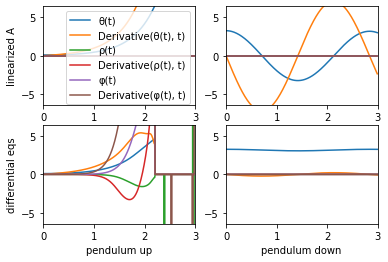

Uncontrolled Pendulum


In [44]:
%matplotlib inline

import matplotlib.pyplot as plt

states = state_x
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq[:, row], label=str(state))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].axis([-0.01, timeline[-1] + 0.01, -(math.pi * 2 + 0.1), math.pi * 2 + 0.1])


axs[0,0].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.show()

print("Uncontrolled Pendulum")

### Controlled Pendulum Simulation

#### Initial Values

In [45]:
dt = 0.01
timeline = np.arange(0., 10., dt)

offset = 0.4
θ_up_0 = offset
θ_down_0 = math.pi + offset

x_0_up = np.float64([θ_up_0, 0, 0, 0, 0, 0])
x_0_down = np.float64([θ_down_0, 0, 0, 0, 0, 0])

#### Control of A Matrix

In [46]:
def apply_k(y_k, t):
    return A_local @ y_k - np.array(B) * np.array(K) @ y_k

A_local = A_j_up
K = K_up

solution_up_lin_k = integrate.odeint(apply_k, x_0_up, timeline)

A_local = A_j_down
K = K_down

solution_down_lin_k = integrate.odeint(apply_k, x_0_down, timeline)

#### Control of diffential equations

In [47]:
def apply_deq_k(y_k, t):
    retA = apply_deq(y_k, t)
    retK = np.array(B) * np.array(K) @ y_k
    return retA - retK

K = K_up
solution_up_deq_k = integrate.odeint(apply_deq_k, x_0_up, timeline)

K = K_down
solution_down_deq_k = integrate.odeint(apply_deq_k, x_0_down, timeline)

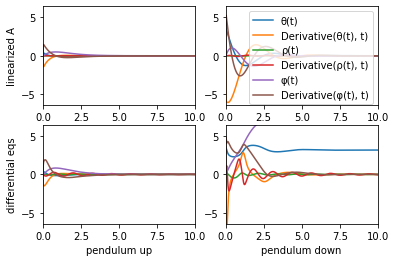

Controlled Pendulum


In [48]:
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq_k[:, row], label=str(state))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].axis([-0.01, timeline[-1] + 0.01, -(math.pi * 2 + 0.1), math.pi * 2 + 0.1])

axs[0,1].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.show()

print("Controlled Pendulum")

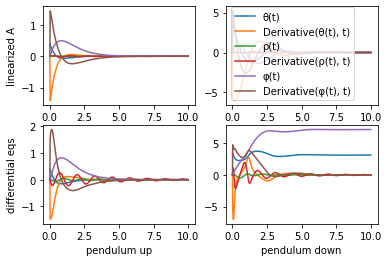

Controlled Pendulum (free axis range)


In [49]:
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq_k[:, row], label=str(state))

axs[0,1].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.show()

print("Controlled Pendulum (free axis range)")

In [50]:
import tqdm

def getPositions(solution):
    # x_ow, y_ow, x_iw, y_iw, x_m, y_m
    positions = sympy.zeros(6, len(timeline))
    energy = sympy.zeros(5, len(timeline))

    for tp in tqdm.tqdm(range(len(timeline))):
        results = {
            (θ.diff(t, t), 0),
            (θ.diff(t), solution[tp, 1]),
            (θ, solution[tp, 0]),
            (ρ.diff(t, t), 0),
            (ρ.diff(t), solution[tp, 3]),
            (ρ, solution[tp, 2]),
            (φ.diff(t, t), 0),
            (φ.diff(t), solution[tp, 5]),
            (φ, solution[tp, 4]),
            (y.diff(t, t), 0),
            (y.diff(t), 0),
            (y, 0)
        }
        positions[0, tp] = x_ow.subs(specs).subs(results)
        positions[1, tp] = y_ow.subs(specs).subs(results)
        positions[2, tp] = x_iw.subs(specs).subs(results)
        positions[3, tp] = y_iw.subs(specs).subs(results)
        positions[4, tp] = x_m.subs(specs).subs(results)
        positions[5, tp] = y_m.subs(specs).subs(results)
        # energy[0, tp] = T.subs(specs).subs(results)
        # energy[1, tp] = V.subs(specs).subs(results)
        # energy[2, tp] = L.subs(specs).subs(results)
        # energy[3, tp] = energy[0, tp] - energy[1, tp]
        # energy[4, tp] = energy[0, tp] + energy[1, tp]
    return positions

positions_up = getPositions(solution_up_deq_k)
positions_down = getPositions(solution_down_deq_k)

100%|██████████| 1000/1000 [00:37<00:00, 26.96it/s]


In [51]:
solution = solution_down_deq_k
positions = positions_down

In [52]:
solution = solution_up_deq_k
positions = positions_up

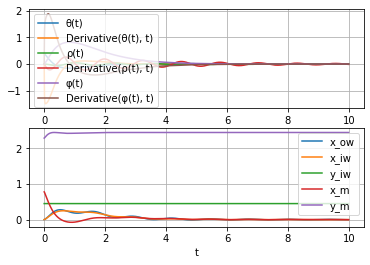

In [53]:
fig, axs = plt.subplots(2)

for row, state in enumerate(states):
    axs[0].plot(timeline, solution[:, row], label=str(state))

axs[1].plot(timeline, positions[0, :].T, label='x_ow')
# axs[1].plot(timeline, positions[1, :].T, label='y_ow')
axs[1].plot(timeline, positions[2, :].T, label='x_iw')
axs[1].plot(timeline, positions[3, :].T, label='y_iw')
axs[1].plot(timeline, positions[4, :].T, label='x_m')
axs[1].plot(timeline, positions[5, :].T, label='y_m')

axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

axs[1].set_xlabel('t')

plt.show()

### Robot Animation

In [54]:
import time

import numpy as np
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool, Range
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [55]:
N = 3
x_dots = np.random.random(size=N) * 5
y_dots = np.random.random(size=N) * 5

c_ow = float(r_3.subs(specs))
c_iw = float(r_1.subs(specs))
c_m = float(r_1.subs(specs))

radii = [c_ow, c_iw, c_m]
colors = ["#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x_dots, 30+2*y_dots)]

radii

[1.2, 0.25, 0.25]

In [56]:
TOOLS="crosshair,pan,wheel_zoom,box_zoom,reset,tap,box_select,lasso_select"

p = figure(tools=TOOLS, x_range = [-5,5], y_range = [-5,5])
p.axis.major_label_text_font_size = "24px"
hover = HoverTool(tooltips=None, mode="vline")
p.add_tools(hover)
r = p.circle(x_dots, y_dots, radius=radii, 
             fill_color=colors, fill_alpha=0.6, line_color=None, 
             hover_fill_color="black", hover_fill_alpha=0.7, hover_line_color=None)

In [57]:
# get and explicit handle to update the next show cell with
target = show(p, notebook_handle=True)

In [58]:
i = 0
for tp in range(len(timeline)):
    i +=1 
    p.title.text = str(i)

    # r.data_source.data['x'] = np.array([1, 2, 3 ])
    r.data_source.data['x'] = np.array([float(positions[0, tp]), float(positions[2, tp]), float(positions[4, tp]) ])
    r.data_source.data['y'] = np.array([float(positions[1, tp]), float(positions[3, tp]), float(positions[5, tp]) ])

    # push updates to the plot continuously using the handle (intererrupt the notebook kernel to stop)
    push_notebook(handle=target)
    time.sleep(dt)